In [97]:
import matplotlib.pyplot as plt
import numpy as np
import cv2, os
import random

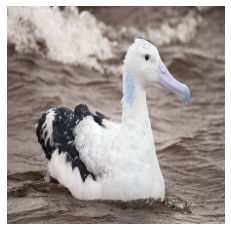

In [6]:
DATASET_PATH = '../dataset/birds/'
image        = cv2.imread(f'{DATASET_PATH}/test/ALBATROSS/3.jpg')

plt.imshow(image)
plt.axis(False)

h, w = image.shape[:2]
center_x, center_y = w // 2, h // 2

In [7]:
def draw_rectangle(img: np.array, coords: dict, color: tuple, fill_mode: str = None) -> np.array: 
    rec_image = cv2.rectangle(img, (coords['x1'], coords['y1']), 
                                (coords['x2'], coords['y2']), color, 1 if fill_mode == None else -1)
    return rec_image

## **IoU (Intersection over Union)을 구현해보자**
- Ground Truth의 좌표와 임의의 predict 좌표는 단순히 이미지의 중심점에서 떨어진 정도를 입력생성하였다.

(-0.5, 223.5, 223.5, -0.5)

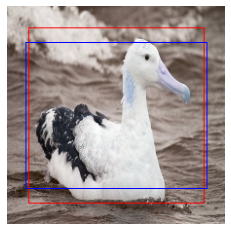

In [8]:
## Predicted Box의 좌표를 생성하기 위해 중심으로 부터 박스의 w//2를 임의로 생성한다.
random_x = np.random.randint(60, w // 2, 1)[0]
random_y = np.random.randint(60, h // 2, 1)[0]

## Ground Truth Box 좌표
gt_coords   = {'x1' : center_x - 90, 'y1' : center_y - 90, 
               'x2' : center_x + 90, 'y2' : center_y + 90}

## Predicted Box 좌표
pred_coords = {'x1' : center_x - random_x, 'y1' : center_y - random_y, 
               'x2' : center_x + random_x, 'y2' : center_y + random_y}

## Groud Truth Box와 Predicted Box 표시
rec_image = draw_rectangle(image, gt_coords, (255, 0, 0))
rec_image = draw_rectangle(rec_image, pred_coords, (0, 0, 255))

plt.imshow(rec_image)
plt.axis(False)

iou : 0.811


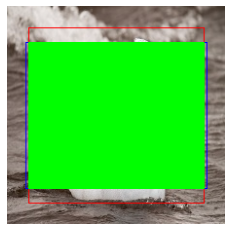

In [9]:
def get_iou(gt_coords: dict, pred_coords: dict) -> tuple:
    
    ## gt box와 predict box 좌표값
    x1_g, y1_g, x2_g, y2_g = gt_coords['x1'], gt_coords['y1'], gt_coords['x2'], gt_coords['y2'] 
    x1_p, y1_p, x2_p, y2_p = pred_coords['x1'], pred_coords['y1'], pred_coords['x2'], pred_coords['y2']
    
    ## inter section box의 좌표 구하는 부분
    x1, y1 = max(x1_g, x1_p), max(y1_g, y1_p)
    x2, y2 = min(x2_g, x2_p), min(y2_g, y2_p)
    
    ## gt box의 넓이와 predict box의 넓이 구하는 부분
    area_g = abs(y2_g - y1_g) * abs(x2_g - x1_g)
    area_p = abs(y2_p - y1_p) * abs(x2_p - x1_p)
    
    inter_coords = {'x1' : x1, 'y1' : y1, 'x2' : x2, 'y2' : y2}
    
    ## intersection의 넓이와 union의 넓이를 구하는 부분
    ## union은 intersection이 두 번 겹치므로, area_g와 area_p를 더한값에서 area_iter를 빼준다.
    area_inter   = abs(y2 - y1) * abs(x2 - x1)
    area_union   = area_g + area_p - area_inter
    
    return area_inter / area_union, inter_coords
    
iou, coords = get_iou(gt_coords, pred_coords)
iou_image = draw_rectangle(rec_image, coords, (0, 255, 0), fill_mode = 'f')

plt.imshow(iou_image)
plt.axis(False)

print(f'iou : {iou:.3f}')

## **NMS (Non-Maximum Suppression)을 구현해보자**
- IoU 때와는 실험을 조금 다르게 해본다.
- NMS는 Predicted Box를 생성할 때 이미지의 중심을 기준으로 하지않고,  
  그냥 아무렇게나 무작위로 생성해본다.

In [41]:
from collections import deque

In [116]:
conf_threshold = 0.4
iou_threshold  = 0.3

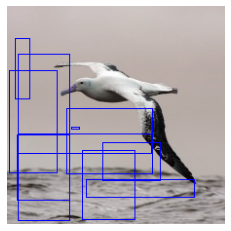

In [117]:
image = cv2.imread(f'{DATASET_PATH}/test/ALBATROSS/1.jpg')
plt.imshow(image)
plt.axis(False)

im_nms = image.copy()
bboxes = []

## bbox들을 생성해보자
for _ in range(10):
    x1 = np.random.randint(0, w - 30)
    x2 = np.random.randint(x1, w)
    
    y1 = np.random.randint(0, h - 30)
    y2 = np.random.randint(y1, h)
    
    conf = np.random.rand(1)[0]
    lb   = random.choice(['bird', 'dog', 'cat'])
    bboxes.append([conf, x1, x2, y1, y2, lb])
    
## bbox들을 그려보자
for bbox in bboxes:
    
    _, x1, y1, x2, y2 , _ = bbox
    coords = {'x1' : x1, 'y1' : y1, 'x2' : x2, 'y2' : y2}    
    rec_image2 = draw_rectangle(image, coords, (0, 0, 255))

plt.imshow(rec_image2)

In [118]:
def NMS(bboxes: list) -> list:
    
    fix_bboxes = []
    bboxes_w_nms = []
    
    ## 1차적으로 confidence threshold를 통해 일차적으로 걸러준다.
    for bbox in bboxes: 
        if bbox[0] > conf_threshold: fix_bboxes.append(bbox)
    
    ## 제거한 박스들에서 confidence 값을 기준으로 내림차순 정렬
    fix_bboxes = sorted(fix_bboxes, key = lambda x: x[0])[::-1]
    
    fix_bboxes = [
        {'conf' : b[0], 'x1' : b[1], 'y1' : b[2], 'x2' : b[3], 'y2' : b[4], 'lb' : b[5]}
        for b in fix_bboxes
    ]
    fix_bboxes = deque(fix_bboxes)
    
    while fix_bboxes:
        base_bbox = fix_bboxes.popleft()
        fix_bboxes = deque([
            box for box in fix_bboxes
            if (get_iou(base_bbox, box)[0] < iou_threshold)
                or (base_bbox['lb'] != box['lb'])
        ])
        
        bboxes_w_nms.append(base_bbox)
    
    return bboxes_w_nms

[1]. {'conf': 0.7763782216508661, 'x1': 23, 'y1': 95, 'x2': 8, 'y2': 33, 'lb': 'dog'}
[2]. {'conf': 0.7671226588159376, 'x1': 148, 'y1': 151, 'x2': 11, 'y2': 131, 'lb': 'bird'}
[3]. {'conf': 0.7200093164780393, 'x1': 11, 'y1': 49, 'x2': 64, 'y2': 220, 'lb': 'dog'}
[4]. {'conf': 0.5780713601904616, 'x1': 192, 'y1': 196, 'x2': 81, 'y2': 178, 'lb': 'dog'}


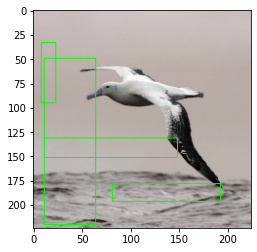

In [119]:
nms_boxes = NMS(bboxes)
for idx, nms_box in enumerate(nms_boxes, 1):
    
    print(f'[{idx}]. {nms_box}')
    rec_image3 = draw_rectangle(im_nms, nms_box, (0, 255, 0))
                                
plt.imshow(rec_image3)

- 제대로 동작하는지 확인해보기 위해 유효한 값을 넣어 테스트 해본다

0.7777777777777778
0.7777777777777778
0.3230769230769231
0.3559322033898305
0.75
0.6375


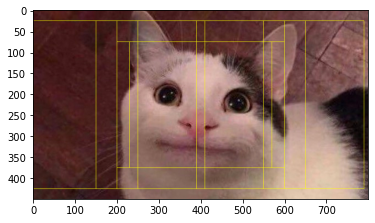

In [120]:
cat_image = cv2.imread('../dataset/dummy/cat.jpg')
cat_image = cv2.cvtColor(cat_image, cv2.COLOR_BGR2RGB)

cat_nms = cat_image.copy()
center_x, center_y = cat_image.shape[1] // 2, cat_image.shape[0] // 2

cat_bboxes = [
                [0.997, center_x - 200, center_y - 200, center_x + 200, center_y + 200, 'cat'],
                [0.980, center_x - 250, center_y - 200, center_x + 150, center_y + 200, 'cat'],
                [0.981, center_x - 150, center_y - 200, center_x + 250, center_y + 200, 'cat'],
                [0.571, center_x - 450, center_y - 200, center_x + 10, center_y + 200, 'cat'],
                [0.791, center_x - 10, center_y - 200, center_x + 390, center_y + 200, 'cat'],
                [0.867, center_x - 200, center_y - 150, center_x + 200, center_y + 150, 'cat'],
                [0.779, center_x - 170, center_y - 150, center_x + 170, center_y + 150, 'cat']
    
            ]

for cat_bbox in cat_bboxes:
    _, x1, y1, x2, y2, _ = cat_bbox
    cat_coord = {'x1' : x1, 'y1' :y1, 'x2': x2, 'y2' : y2}
    cat_rect  = draw_rectangle(cat_image, cat_coord, (255, 255, 0))
                               
plt.imshow(cat_rect)

for cat_bbox in cat_bboxes[1:]:
    gt_box = {k : v for k, v in zip(['x1', 'y1', 'x2', 'y2'], cat_bboxes[0][1:-1])}
    pred_box = {k : v for k, v in zip(['x1', 'y1', 'x2', 'y2'], cat_bbox[1:-1])}
    
    iou, _ = get_iou(gt_box, pred_box)
    print(iou)

[1]. {'conf': 0.997, 'x1': 200, 'y1': 25, 'x2': 600, 'y2': 425, 'lb': 'cat'}


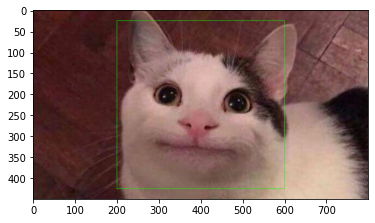

In [121]:
nms_boxes = NMS(cat_bboxes)
for idx, nms_box in enumerate(nms_boxes, 1):
    
    print(f'[{idx}]. {nms_box}')
    cat_nms = draw_rectangle(cat_nms, nms_box, (0, 255, 0))
                                
plt.imshow(cat_nms)